Author:  Hao Jiang
## Goal for this notebook
Use version 2 data cleaning and try prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train.head()
# test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# combine the data and take all of the feature. This is for easier feature engineering. 
all_data = pd.concat((train.iloc[:,1:-1], test.iloc[:,1:-1]))
Y = train["SalePrice"]

# remember the length of train data
trainLen = len(train)

Due to previous prediction, we could see that living area and other area infomation is a crucial predictor to final sold price. Insteed of the sold price, price per SF could be a better feature to compare the effect of other features. But first, we need to have some conversions on these continuouse data.  
To begin with, we can see that GrLivArea = 1stFlrSF + 2ndFlrSF, TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF. So if seems better to reduce the features here.

In [4]:
# There is a na TotalBsmtSF value in the test set for 
all_data.loc[all_data["TotalBsmtSF"].isnull(),'TotalBsmtSF'] = 0

all_data["1stFlrSFRatio"] = all_data["1stFlrSF"] * 1.0 / all_data["GrLivArea"]
all_data["BsmtUnfSFRatio"] = all_data["BsmtUnfSF"] * 1.0 / all_data["TotalBsmtSF"]
all_data["BsmtFinSF1Ratio"] = all_data["BsmtFinSF1"] * 1.0 / all_data["TotalBsmtSF"]
all_data["BsmtFinSF2Ratio"] = all_data["BsmtFinSF2"] * 1.0 / all_data["TotalBsmtSF"]
# BsmtFinSF1 & 2 would be latter merged with type

In [5]:
# Add a variable for total porch Area
all_data['TotalPorchSF'] = all_data[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis = 1)
# Add a variable for total living area
all_data['TotalLivArea'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']


In [6]:
# Drop already processed features
all_data = all_data.drop([
        '1stFlrSF','2ndFlrSF',
        'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
], axis=1)

In [7]:
continuous_feats = pd.Index([name for name in all_data.columns if "Area" in name or "SF" in name] + ['LotFrontage', 'MiscVal'])
area_feats = pd.Index([name for name in continuous_feats if 'Ratio' not in name])
len(area_feats), len(continuous_feats)

(12, 16)

In [8]:
# matplotlib.rcParams['figure.figsize'] = (12.0, 18.0)

# # Non zeor non null histogram
# for i in range(len(area_feats)):
#     plt.subplot(4,3, i + 1)
#     plt.hist(all_data[area_feats[i]].loc[all_data[area_feats[i]] > 0], bins=20)
#     plt.title(area_feats[i])

Many of these values are skewed. Let's convert them (apart from the ratio features).

In [9]:
skewed_feats = all_data[area_feats].apply(lambda x: skew(x[x > 0]))
skewed_feats = skewed_feats[skewed_feats > 0.9].index
skewed_feats

Index([u'GrLivArea', u'LotArea', u'LowQualFinSF', u'MasVnrArea',
       u'TotalBsmtSF', u'WoodDeckSF', u'TotalPorchSF', u'TotalLivArea',
       u'LotFrontage', u'MiscVal'],
      dtype='object')

In [10]:
# Seems fine, let's convert. But before converting them that's make a feature for price per SF LivArea

YPerSF = Y / all_data['TotalLivArea'][:trainLen]
Y = np.log1p(Y)
YPerSF = np.log1p(YPerSF)
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
# # Not let's check the scatter of these values to price
# matplotlib.rcParams['figure.figsize'] = (12.0, 18.0)

# # Non zeor non null histogram
# for i in range(len(continuous_feats)):
#     plt.subplot(4,4, i + 1)
#     plt.scatter(y = Y, x = all_data[continuous_feats[i]][:trainLen])
#     plt.title(continuous_feats[i])

We can see that TotalLivingArea is Stronging correlated to price.

According to hint, there're some outliers. Let's check the distribution of total living area for both train and test set.

In [12]:
# matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
# plt.subplot(121)
# all_data[:trainLen]['TotalLivArea'].hist(bins = 20)
# plt.title('Train set total living area hist')
# plt.subplot(122)
# all_data[trainLen:]['TotalLivArea'].hist(bins = 20)
# plt.title('Test set total living area hist')

It seems that we could ignore data for log1p(TtllivingArea) < 6

In [13]:
all_data.index[all_data['TotalLivArea'] <= 6]

Int64Index([533], dtype='int64')

In [14]:
# Latter
# all_data[:trainLen] = all_data[:trainLen].drop([533], axis = 0).shape
# all_data[:trainLen].shape

Basically that's all for continuous data. Now that's convert Ordinal ones.

In [15]:
# LotShape
all_data['LotShape'] = all_data['LotShape'].replace(['IR3','IR2','IR1' ,'Reg'], [1,2,3,4])
all_data['LandContour'] = all_data['LandContour'].replace(['Low', 'HLS', 'Bnk','Lvl'], [1,2,3,4])
all_data['Utilities'] = all_data['Utilities'].replace(['ELO','NoSeWa','NoSewr','AllPub'], [1,2,3,4])
all_data['LandSlope'] = all_data['LandSlope'].replace(['Sev' , 'Mod', 'Gtl'], [1,2,3])
all_data['ExterQual'] = all_data['ExterQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['ExterCond'] = all_data['ExterCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['BsmtQual'] = all_data['BsmtQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['BsmtCond'] = all_data['BsmtCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['BsmtExposure'] = all_data['BsmtExposure'].replace(['No', 'Mn', 'Av', 'Gd'], [1,2,3,4])
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].replace(['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [1,2,3,4,5,6])
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].replace(['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [1,2,3,4,5,6])
all_data['HeatingQC'] = all_data['HeatingQC'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['KitchenQual'] = all_data['KitchenQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['Functional'] = all_data['Functional'].replace(['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'], [
        1,2,3,4,5,6,7,8])
all_data['FireplaceQu'] = all_data['FireplaceQu'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['GarageFinish'] = all_data['GarageFinish'].replace(['Unf', 'RFn', 'Fin'], [1,2,3])
all_data['GarageQual'] = all_data['GarageQual'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['GarageCond'] = all_data['GarageCond'].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
all_data['PoolQC'] = all_data['PoolQC'].replace(['Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4])
all_data['Fence'] = all_data['Fence'].replace(['MnWw', 'GdWo', 'MnPrv', 'GdPrv'], [1,2,3,4])

In [16]:
# Ordinal check
ord_feats = pd.Index(['LotShape','LandContour','Utilities','LandSlope',
                      'OverallQual','OverallCond','ExterQual','ExterCond',
                      'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                      'BsmtFinType2','HeatingQC','KitchenQual','Functional',
                      'FireplaceQu','GarageFinish','GarageQual','GarageCond',
                      'PoolQC','Fence'])
all_data[ord_feats] = all_data[ord_feats].fillna(0)
len(ord_feats)

22

In [17]:
# # Not let's check the boxplot of these values to price per sf
# matplotlib.rcParams['figure.figsize'] = (12.0, 24.0)

# # Non zeor non null histogram
# for i in range(len(ord_feats)):
#     plt.subplot(6,4, i + 1)
#     sns.boxplot(y = YPerSF, x = all_data[:trainLen][ord_feats[i]])

Generally, these ordinal data are correlated to price per SF, but not all of them are strictly as so.
Further more, sometimes na data does not seems to be worse.

We'll jsut try to see how these works first.

Now let's try to handle the discrete data.

In [18]:
# Let's add time interval in year between build and sold time.
all_data['BltYears'] = all_data['YrSold'] -  all_data['YearBuilt']
all_data['RemYears'] = all_data['YrSold'] -  all_data['YearRemodAdd']
all_data['GaBltyears'] = all_data['YrSold'] -  all_data['GarageYrBlt']
all_data = all_data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt'], axis = 1)

In [19]:
# MoSold seems more like a categorical data, let's check the distribution
# sns.boxplot(y = Y, x = all_data[:trainLen]['MoSold'])
all_data['MoSold'] = all_data['MoSold'].astype('category')

In [20]:
all_data['CentralAir'] = all_data['CentralAir'].replace(['N','Y'], [0,1])

Finally let's fill in na data and one-hot encoding nomincal ones

In [21]:
# check na value count
nullCnt = pd.DataFrame({'nullNums' : all_data.isnull().sum()})
nullCnt['DataType'] = all_data[nullCnt.index].dtypes
print nullCnt[nullCnt['nullNums'] > 0].sort_values(by = 'DataType')

                 nullNums DataType
LotFrontage           486  float64
BsmtFinSF1Ratio        79  float64
BsmtUnfSFRatio         79  float64
MasVnrArea             23  float64
BsmtFinSF2Ratio        79  float64
GarageCars              1  float64
GaBltyears            159  float64
BsmtHalfBath            2  float64
BsmtFullBath            2  float64
GarageArea              1  float64
Exterior2nd             1   object
GarageType            157   object
Exterior1st             1   object
MSZoning                4   object
Electrical              1   object
MasVnrType             24   object
MiscFeature          2814   object
SaleCondition        1459   object
SaleType                1   object
Alley                2721   object


Based on previous data cleaning we know that we should fill in LatFrontage data.  
For GaBltyears, we will just set them to 999

In [22]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(all_data.loc[all_data['LotFrontage'].notnull(), ['LotArea']], all_data.loc[all_data['LotFrontage'].notnull(), ['LotFrontage']])
all_data.loc[all_data['LotFrontage'].isnull(), ['LotFrontage']] = reg.predict(all_data.loc[all_data['LotFrontage'].isnull(), ['LotArea']])

In [23]:
all_data.loc[all_data['GaBltyears'].isnull(), 'GaBltyears'] = 999
# Fill na with 0
all_data[all_data.columns[all_data.dtypes == 'float64']] = all_data[all_data.columns[all_data.dtypes == 'float64']].fillna(0)

In [24]:
# There're several pairs of feature that should be merged when one-hot encoded

# Deal with Exterior
for name in all_data["Exterior1st"].dropna().unique():
    all_data[name] = 1 * ((all_data["Exterior1st"] == name) | (all_data["Exterior2nd"] == name))

# Deal with Condition
for name in all_data["Condition1"].dropna().unique():
    all_data[name] = 1 * ((all_data["Condition1"] == name) | (all_data["Condition2"] == name))

In [25]:
# Drop those features that we have converted already

all_data = all_data.drop(['Exterior1st','Exterior2nd'], axis=1)
all_data = all_data.drop(['Condition1','Condition2'], axis=1)

In [26]:
# one-hot encode category data
all_data = pd.get_dummies(all_data)
all_data.shape
# all_data.head()

(2919, 204)

In [59]:
X_train = all_data[:trainLen]
X_test  = all_data[trainLen:]

## Model

### Regularized model
Same as before try both ridge and lasso

In [28]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import model_selection, metrics   #Additional scklearn functions

In [29]:
# Search or the best result for ridge

ridge_param_test = {
#  'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
    'alpha' : np.arange(3,10,0.5)
}

ridge_search = GridSearchCV(
    estimator = Ridge(),
    param_grid = ridge_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=1,
    iid=False, 
    cv=5
)
ridge_search.fit(X_train,Y)
zip(np.sqrt(-ridge_search.cv_results_['mean_test_score']),ridge_search.cv_results_['params']), ridge_search.best_params_,np.sqrt(- ridge_search.best_score_)

([(0.12657768119904939, {'alpha': 3.0}),
  (0.12642190979310594, {'alpha': 3.5}),
  (0.12630676846364214, {'alpha': 4.0}),
  (0.12622258909601383, {'alpha': 4.5}),
  (0.12616274352176607, {'alpha': 5.0}),
  (0.12612248203865153, {'alpha': 5.5}),
  (0.12609827995585635, {'alpha': 6.0}),
  (0.12608744648946568, {'alpha': 6.5}),
  (0.12608787878460054, {'alpha': 7.0}),
  (0.12609790080266184, {'alpha': 7.5}),
  (0.12611615415481803, {'alpha': 8.0}),
  (0.12614152197116285, {'alpha': 8.5}),
  (0.12617307447276982, {'alpha': 9.0}),
  (0.12621002920600088, {'alpha': 9.5})],
 {'alpha': 6.5},
 0.12608744648946568)

In [30]:
lasso_param_test = {
#     'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,3]
    'alpha': np.arange(0.0002,0.0007,0.00005)
}

lasso_search = GridSearchCV(
    estimator = Lasso(),
    param_grid = lasso_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=1,
    iid=False, 
    cv=5
)
lasso_search.fit(X_train,Y)
zip(np.sqrt(-lasso_search.cv_results_['mean_test_score']),lasso_search.cv_results_['params']), lasso_search.best_params_,np.sqrt(- lasso_search.best_score_)

([(0.12280076130076141, {'alpha': 0.00020000000000000001}),
  (0.12235461683864593, {'alpha': 0.00025000000000000001}),
  (0.12210850529578546, {'alpha': 0.00030000000000000003}),
  (0.12201581462729716, {'alpha': 0.00035}),
  (0.12207437181538619, {'alpha': 0.00039999999999999996}),
  (0.12215098774943567, {'alpha': 0.00044999999999999999}),
  (0.12228167684602211, {'alpha': 0.00050000000000000001}),
  (0.12244576631742551, {'alpha': 0.00054999999999999992}),
  (0.12265640700537676, {'alpha': 0.00059999999999999995}),
  (0.12290130355329881, {'alpha': 0.00064999999999999997})],
 {'alpha': 0.00035},
 0.12201581462729716)

As before LASSO works. Better. Let's take a look at the top features first.

In [31]:
model_lasso = Lasso(alpha = 0.00035)
model_lasso.fit(X_train, Y)

Lasso(alpha=0.00035, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
lasso_coef = pd.Series(model_lasso.coef_, index = X_train.columns)

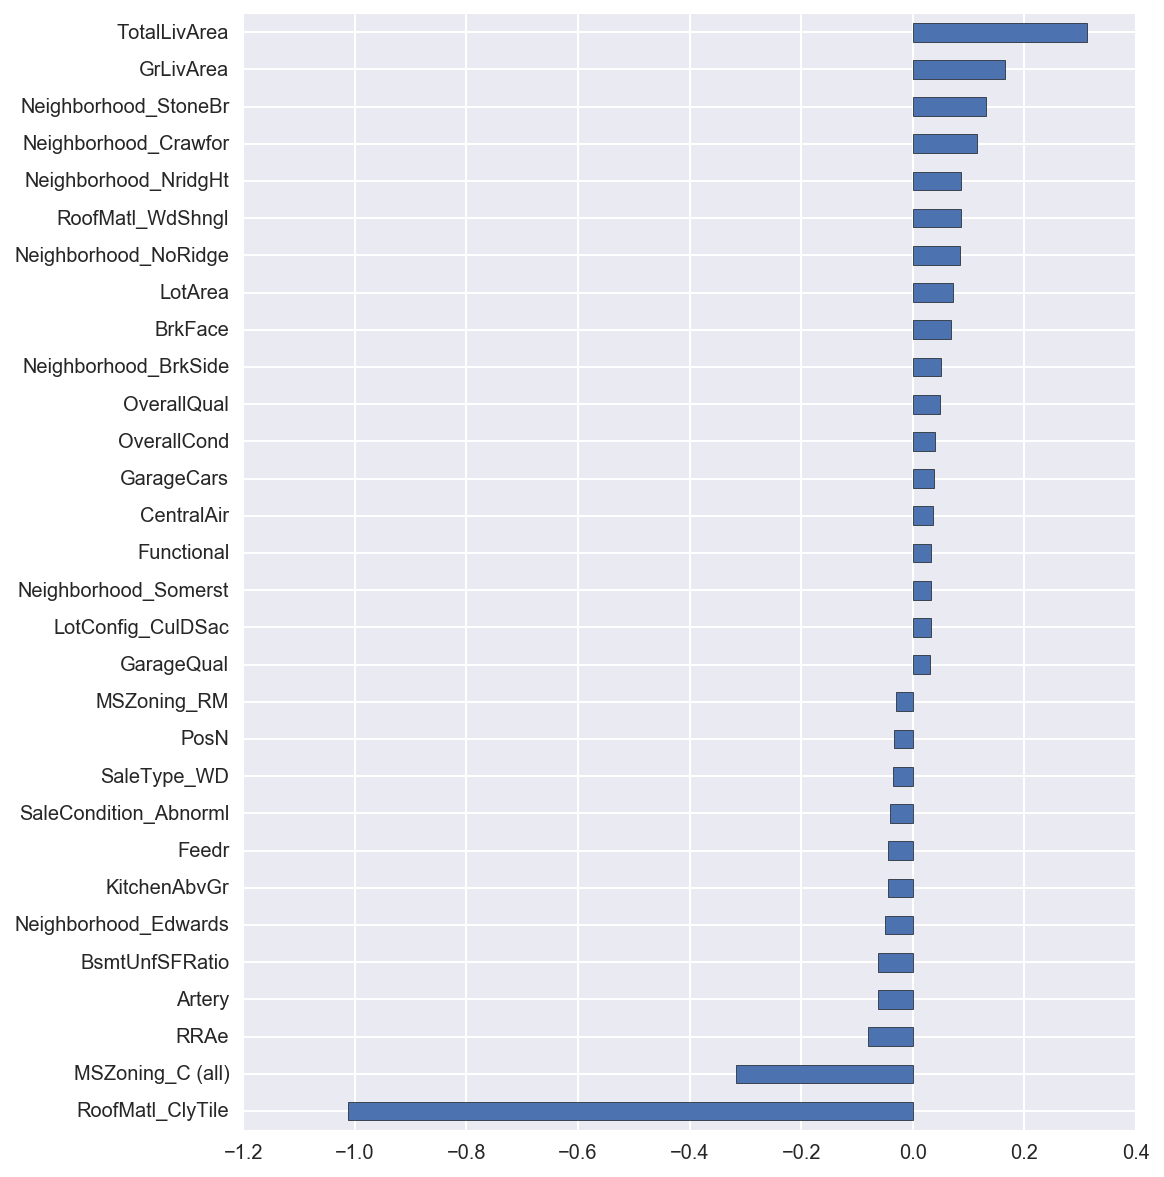

In [33]:
lasso_top30_feats = abs(lasso_coef).sort_values().tail(30).index
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
lasso_coef[lasso_top30_feats].sort_values().plot(kind = "barh")

What if we feed none zero Laso features into Ridge?

In [34]:
lasso_nonzero_coef = lasso_coef[abs(lasso_coef) > 0].index
# Search or the best result for ridge

ridge_param_test = {
#  'alpha':[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
    'alpha' : np.arange(0.5,2,0.1)
}

ridge_search = GridSearchCV(
    estimator = Ridge(),
    param_grid = ridge_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=1,
    iid=False, 
    cv=5
)
ridge_search.fit(X_train[lasso_nonzero_coef],Y)
zip(np.sqrt(-ridge_search.cv_results_['mean_test_score']),ridge_search.cv_results_['params']), ridge_search.best_params_,np.sqrt(- ridge_search.best_score_)

([(0.12076920893311258, {'alpha': 0.5}),
  (0.12074258917229241, {'alpha': 0.59999999999999998}),
  (0.12072227399145859, {'alpha': 0.69999999999999996}),
  (0.12070653947596985, {'alpha': 0.79999999999999993}),
  (0.12069427871702409, {'alpha': 0.89999999999999991}),
  (0.12068475853705078, {'alpha': 0.99999999999999989}),
  (0.12067747839065973, {'alpha': 1.0999999999999999}),
  (0.12067208615672945, {'alpha': 1.1999999999999997}),
  (0.12066832660418816, {'alpha': 1.2999999999999998}),
  (0.12066600913922024, {'alpha': 1.3999999999999999}),
  (0.12066498720704621, {'alpha': 1.4999999999999998}),
  (0.12066514489044788, {'alpha': 1.5999999999999996}),
  (0.12066638803850266, {'alpha': 1.6999999999999997}),
  (0.12066863829708771, {'alpha': 1.7999999999999998}),
  (0.12067182902793575, {'alpha': 1.8999999999999997})],
 {'alpha': 1.4999999999999998},
 0.12066498720704621)

Wow!! Ridge is becoming so much better!!!
It seems that we just need less feats!!

In [35]:
model_ridge = Ridge(alpha = 1.5)
model_ridge.fit(X_train[lasso_nonzero_coef], Y)
ridge_coef = pd.Series(model_ridge.coef_, index = lasso_nonzero_coef)

### KNN regressor

In [36]:
from sklearn.neighbors.regression import KNeighborsRegressor

In [37]:
# # Search or the best result for knn

# knn_param_test = {
#     'n_neighbors' : range(3,22,3)
# }

# knn_search = GridSearchCV(
#     estimator = KNeighborsRegressor(
#         n_jobs = 4
#     ),
#     param_grid = knn_param_test, 
#     scoring='neg_mean_squared_error',
#     n_jobs=1,
#     iid=False, 
#     cv=5
# )
# knn_search.fit(X_train[lasso_top30_feats],Y)
# zip(np.sqrt(-knn_search.cv_results_['mean_test_score']),knn_search.cv_results_['params']), knn_search.best_params_,np.sqrt(-knn_search.best_score_)

([(0.18311567551028529, {'n_neighbors': 3}),
  (0.17862462451160246, {'n_neighbors': 6}),
  (0.17827959138515895, {'n_neighbors': 9}),
  (0.1785643288919217, {'n_neighbors': 12}),
  (0.18132583066601382, {'n_neighbors': 15}),
  (0.18231339535695559, {'n_neighbors': 18}),
  (0.18420088326624084, {'n_neighbors': 21})],
 {'n_neighbors': 9},
 0.17827959138515895)

So now we know that for knn less feats seems work better. Let's try two things.  
 * Find the best numbers of feat for the regressor
 * Try to change weight
 * Try to change feature scale

In [38]:
# from sklearn.model_selection import cross_val_score
# # First let's see best numbers of feats without weight setting
# lasso_feats_weight = abs(lasso_coef).sort_values()
# # ridge_feats_weight = abs(ridge_coef).sort_values()

# # for i in range(20,61,10):
# for i in range(46,87,4):
#     topi_score = cross_val_score(
#         estimator = KNeighborsRegressor(
#             n_jobs = 4,
#             n_neighbors = 9
#         ),
#         X = X_train[lasso_feats_weight.tail(i).index],
#         y = Y,
#         scoring='neg_mean_squared_error',
#         n_jobs=1,
#         cv = 5,
#     )
#     print i, np.sqrt(-topi_score).mean()

46 0.171275057035
50 0.166891198644
54 0.167509699897
58 0.168843938849
62 0.168199950918
66 0.169760571112
70 0.166909888055
74 0.16614671656
78 0.168809022205
82 0.169541101
86 0.177920814609


Around 50 or 74 neighbors seem to be the best choice.
Next let's try to set weight inverse to distance 

In [39]:
# # for i in range(20,61,10):
# for i in range(46,87,4):
#     topi_score = cross_val_score(
#         estimator = KNeighborsRegressor(
#             n_jobs = 4,
#             n_neighbors = 9,
#             weights = 'distance'
#         ),
#         X = X_train[lasso_feats_weight.tail(i).index],
#         y = Y,
#         scoring='neg_mean_squared_error',
#         n_jobs=1,
#         cv = 5,
#     )
#     print i, np.sqrt(-topi_score).mean()

46 0.169334277407
50 0.165272533722
54 0.165831058481
58 0.166937551855
62 0.166548750938
66 0.168060604161
70 0.165257093845
74 0.164314638161
78 0.167160348518
82 0.167876425211
86 0.175956052431


Seems slightly better than uniform weight. Now lets try to change scale

In [40]:
# lasso_feats_rescale = abs((X_train[lasso_coef[lasso_coef != 0].index] * lasso_coef[lasso_coef[lasso_coef != 0].index]).mean()).sort_values()

# # ridge_feats_rescale = abs((X_train[ridge_feats_weight.index] * ridge_coef[ridge_feats_weight.index]).mean()).sort_values()

# # for i in range(10,81,5):
# for i in range(60,75,2):
#     topi_score = cross_val_score(
#         estimator = KNeighborsRegressor(
#             n_jobs = 4,
#             n_neighbors = 9,
#             weights = 'distance'
#         ),
#         X = X_train[lasso_feats_rescale.tail(i).index] * lasso_feats_weight[lasso_feats_rescale.tail(i).index],
# #         X = X_train[ridge_feats_rescale.tail(i).index] * ridge_feats_weight[ridge_feats_rescale.tail(i).index],
#         y = Y,
#         scoring='neg_mean_squared_error',
#         n_jobs=1,
#         cv = 5,
#     )
#     print i, np.sqrt(-topi_score).mean()

60 0.137058866559
62 0.136865316738
64 0.136283422266
66 0.13632769921
68 0.136566638772
70 0.13652616774
72 0.13643237454
74 0.136091622057


The best performance shows when we rescale all the features and pick the top 64 features.

### RandomForest Again

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [41]:

# # There were some trials before this. So please ignore the specific range here.
# rf_param_test = {
#     "n_estimators"  : range(50,101,10)
# }
# rf_search = GridSearchCV(
#     estimator = RandomForestRegressor(
#         n_estimators = 30, 
#         random_state = 100,
#         max_features = 22,
#         warm_start = True,
#         n_jobs = 4        
#     ),
#     param_grid = rf_param_test,
#     scoring = 'neg_mean_squared_error',
#     n_jobs = 1,
#     iid = False,
#     cv = 5
# )
# rf_search.fit(X_train[lasso_nonzero_coef],Y)
# zip(np.sqrt(-rf_search.cv_results_['mean_test_score']),rf_search.cv_results_['params']), rf_search.best_params_,np.sqrt(-rf_search.best_score_)

([(0.13573681937254126, {'n_estimators': 50}),
  (0.13543759768325256, {'n_estimators': 60}),
  (0.13531414751082679, {'n_estimators': 70}),
  (0.13512718918539923, {'n_estimators': 80}),
  (0.13505655729208368, {'n_estimators': 90}),
  (0.13490702931777893, {'n_estimators': 100})],
 {'n_estimators': 100},
 0.13490702931777893)

In [42]:
rf_score = cross_val_score(
    estimator = RandomForestRegressor(
        n_estimators = 300, 
        random_state = 100,
        max_features = 22,
        n_jobs = 4
    ),
    X = X_train[lasso_nonzero_coef],
    y = Y,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv = 5
)
print np.sqrt(-rf_score).mean()

0.134034785611


### Xgboost

In [41]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [44]:
dtrain = xgb.DMatrix(X_train, label = Y)
dtest = xgb.DMatrix(X_test)

In [63]:
# # All tuning would be done within this cell
# xgb_param_test = {
# #     'max_depth':range(3,8,1),
# #     'min_child_weight':range(1,4,1)
# #     'gamma' : np.arange(0.003, 0.01, 0.0005)
# #     'subsample': np.arange(0.56, 0.61, 0.01),
# #     'colsample_bytree': np.arange(0.62, 0.67, 0.01)
# #     'reg_alpha' : np.arange(7e-6,9e-6,3e-7) # 8.2e-6
# #     'reg_lambda' : np.arange(0.7,1.1,0.03)
# }
# xgb_search = GridSearchCV(
#     estimator = XGBRegressor(
#         learning_rate =0.1,
#         n_estimators=140,
#         max_depth=4,
#         min_child_weight=1,
#         gamma=0.005,
#         subsample=0.57,
#         colsample_bytree=0.66,
#         objective= 'reg:linear',
#         nthread=4,
#         scale_pos_weight=1,
#         reg_alpha = 8.2e-6,
#         seed=100
#     ),
#     param_grid = xgb_param_test,
#     scoring = 'neg_mean_squared_error',
#     n_jobs = 1,
#     iid = False,
#     cv = 5
# )
# xgb_search.fit(X_train, Y)
# zip(np.sqrt(-xgb_search.cv_results_['mean_test_score']),xgb_search.cv_results_['params']), xgb_search.best_params_,np.sqrt(- xgb_search.best_score_)

([(0.12532580265812596, {'reg_lambda': 0.69999999999999996}),
  (0.12312722778277221, {'reg_lambda': 0.72999999999999998}),
  (0.12446991610933382, {'reg_lambda': 0.76000000000000001}),
  (0.12548089462252068, {'reg_lambda': 0.79000000000000004}),
  (0.12573365614325474, {'reg_lambda': 0.82000000000000006}),
  (0.12398830990854401, {'reg_lambda': 0.85000000000000009}),
  (0.1223787084716296, {'reg_lambda': 0.88000000000000012}),
  (0.12431148698803733, {'reg_lambda': 0.91000000000000014}),
  (0.12455279658153419, {'reg_lambda': 0.94000000000000017}),
  (0.12552869171897438, {'reg_lambda': 0.9700000000000002}),
  (0.1220337294557553, {'reg_lambda': 1.0000000000000002}),
  (0.12320254356658709, {'reg_lambda': 1.0300000000000002}),
  (0.12217051530402659, {'reg_lambda': 1.0600000000000003}),
  (0.12363436437349506, {'reg_lambda': 1.0900000000000003})],
 {'reg_lambda': 1.0000000000000002},
 0.1220337294557553)

In [64]:
xgb1_score = cross_val_score(
    estimator = XGBRegressor(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=1,
        gamma=0.005,
        subsample=0.57,
        colsample_bytree=0.66,
        objective='reg:linear',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 8.2e-6,
        seed=100
    ),
    X = X_train,
    y = Y,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv = 5
)
print np.sqrt(-xgb1_score).mean()

0.118522609571


In [74]:
# # All tuning would be done within this cell
# xgb_param_test = {
# #     'max_depth':range(3,8,1),
# #     'min_child_weight':range(1,4,1)
#     'gamma' : np.arange(0.01, 0.07, 0.01)
# #     'subsample': np.arange(0.7, 0.9, 0.03),
# #     'colsample_bytree': np.arange(0.5, 0.7, 0.03)
# #     'reg_alpha' : [1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3]  #1e-6
# #     'reg_lambda' : [0.01, 0.05, 0.1, 0.5, 1, 3, 5]
# }
# xgb_search = GridSearchCV(
#     estimator = XGBRegressor(
#         learning_rate =0.1,
#         n_estimators=140,
#         max_depth=5,
#         min_child_weight=1,
#         gamma=0.03,
#         subsample=0.82,
#         colsample_bytree=0.53,
#         objective= 'reg:linear',
#         nthread=4,
#         scale_pos_weight=1,
#         reg_alpha = 1e-6,
#         seed=100
#     ),
#     param_grid = xgb_param_test,
#     scoring = 'neg_mean_squared_error',
#     n_jobs = 1,
#     iid = False,
#     cv = 5
# )
# xgb_search.fit(X_train[lasso_nonzero_coef], Y)
# zip(np.sqrt(-xgb_search.cv_results_['mean_test_score']),xgb_search.cv_results_['params']), xgb_search.best_params_,np.sqrt(- xgb_search.best_score_)

([(0.12178402370237028, {'gamma': 0.01}),
  (0.12181462655521832, {'gamma': 0.02}),
  (0.12151945665438448, {'gamma': 0.029999999999999999}),
  (0.12188023154930866, {'gamma': 0.040000000000000001}),
  (0.12284715110398453, {'gamma': 0.050000000000000003}),
  (0.12343920626049965, {'gamma': 0.060000000000000005})],
 {'gamma': 0.029999999999999999},
 0.12151945665438448)

In [78]:
xgb2_score = cross_val_score(
    estimator = XGBRegressor(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=5,
        min_child_weight=1,
        gamma=0.03,
        subsample=0.82,
        colsample_bytree=0.53,
        objective= 'reg:linear',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 1e-6,
        seed=100
    ),
    X = X_train[lasso_nonzero_coef],
    y = Y,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    cv = 5
)
print np.sqrt(-xgb2_score).mean()

0.118524630892


### Model stacking

In [43]:
from sklearn.model_selection import KFold

In [66]:
# Add fields into all_data in advance
X_train = pd.concat((X_train, pd.DataFrame(columns = ['RidgePred', 'XGBPred', 'KNNPred', 'RFPred'])))

['KNNPred', 'RFPred', 'RidgePred', 'XGBPred']

In [67]:
# model_ridge & use lasso_coef none zero features
model_knn = KNeighborsRegressor(  # use ridge top 64 weighted features
    n_jobs = 4,
    n_neighbors = 9,
    weights = 'distance'
)
model_rf = RandomForestRegressor( #use lasso_coef none zero features
    n_estimators = 300, 
    random_state = 100,
    max_features = 22,
    n_jobs = 4
)
model_xgb = XGBRegressor( # use all features
    learning_rate =0.01,
    n_estimators=5000,
    max_depth=4,
    min_child_weight=1,
    gamma=0.005,
    subsample=0.57,
    colsample_bytree=0.66,
    objective='reg:linear',
    nthread=4,
    scale_pos_weight=1,
    reg_alpha = 8.2e-6,
    seed=100
)

In [70]:
kf = KFold(n_splits = 5)
for train_index, test_index in kf.split(X_train):
    model_ridge.fit(X_train.loc[train_index,lasso_nonzero_coef], Y.loc[train_index])
    model_knn.fit(X_train.loc[train_index,lasso_feats_rescale.tail(64).index] * lasso_feats_weight[lasso_feats_rescale.tail(64).index], Y.loc[train_index])
    model_rf.fit(X_train.loc[train_index,lasso_nonzero_coef], Y.loc[train_index])
    model_xgb.fit(X_train.loc[train_index,lasso_nonzero_coef], Y.loc[train_index])
    X_train.loc[test_index,'RidgePred'] = model_ridge.predict(X_train.loc[test_index,lasso_nonzero_coef])
    X_train.loc[test_index,'XGBPred']   = model_knn.predict(X_train.loc[test_index,lasso_feats_rescale.tail(64).index] * lasso_feats_weight[lasso_feats_rescale.tail(64).index])
    X_train.loc[test_index,'KNNPred']   = model_rf.predict(X_train.loc[test_index,lasso_nonzero_coef])
    X_train.loc[test_index,'RFPred']    = model_xgb.predict(X_train.loc[test_index,lasso_nonzero_coef])

In [71]:
X_train.tail()

,1stFlrSFRatio,Alley_Grvl,Alley_Pave,Artery,AsbShng,AsphShn,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,...,TotalBsmtSF,TotalLivArea,TotalPorchSF,Utilities,VinylSd,Wd Sdng,WdShing,WoodDeckSF,XGBPred,YrSold
1455,0.578628,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,6.860664,7.863651,3.713572,4.0,1.0,0.0,0.0,0.000000,12.0779,2007.0
1456,1.000000,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,7.341484,8.193124,0.000000,4.0,0.0,0.0,0.0,5.857933,12.2228,2010.0
1457,0.507692,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,...,7.050123,8.158516,4.110874,4.0,0.0,0.0,0.0,0.000000,12.4393,2010.0
1458,1.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,6.983790,7.676474,4.727388,4.0,0.0,0.0,0.0,5.905362,11.8308,2010.0
1459,1.000000,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,7.136483,7.829233,4.234107,4.0,0.0,0.0,0.0,6.602588,11.8692,2008.0


In [73]:
X_test = pd.concat((X_test, pd.DataFrame(columns = ['RidgePred', 'XGBPred', 'KNNPred', 'RFPred'])))
model_ridge.fit(X_train[lasso_nonzero_coef], Y)
model_knn.fit(X_train[lasso_feats_rescale.tail(64).index] * lasso_feats_weight[lasso_feats_rescale.tail(64).index], Y)
model_rf.fit(X_train[lasso_nonzero_coef], Y)
model_xgb.fit(X_train[lasso_nonzero_coef], Y)
X_test.loc[:,'RidgePred'] = model_ridge.predict(X_test[lasso_nonzero_coef])
X_test.loc[:,'XGBPred'] = model_knn.predict(X_test[lasso_feats_rescale.tail(64).index] * lasso_feats_weight[lasso_feats_rescale.tail(64).index])
X_test.loc[:,'KNNPred'] = model_rf.predict(X_test[lasso_nonzero_coef])
X_test.loc[:,'RFPred'] = model_xgb.predict(X_test[lasso_nonzero_coef])

In [76]:
temp_train = X_train.loc[:,['RidgePred', 'XGBPred', 'KNNPred', 'RFPred']]
temp_train.loc[:,'Id'] = train.Id
temp_test = X_test.loc[:,['RidgePred', 'XGBPred', 'KNNPred', 'RFPred']]
temp_test.loc[:,'Id'] = test.Id

In [77]:
temp_train.to_csv("temp_train.csv", index = False)
temp_test.to_csv("temp_test.csv", index = False)